In [1]:
import sys
from os import path
import os
from dotenv import load_dotenv
import random

random_seed = 42
load_dotenv()
sys.path.append(path.dirname(os.getcwd()))

# Analyze Experiments Result

What do we want to extract from the data?

In [4]:
from project.experiments.models import Experiment
from project.models import YouTubeVideoInfo
import pandas as pd
import json

experiment_file_names_by_prompt_id = {
    # Llama 3.2 Vision
    "simple+thumbnail": "/home/leoli/Uni/Polimi/Thesis/master-thesis/notebooks/experiment-1734524777.json",
    "description+thumbnail": "/home/leoli/Uni/Polimi/Thesis/master-thesis/notebooks/experiment-1738246121.json",
    
    # "small models"
    #"simple": "/home/leoli/Uni/Polimi/Thesis/master-thesis/notebooks/experiment-1733312932.json", 
    #"description": "/home/leoli/Uni/Polimi/Thesis/master-thesis/notebooks/experiment-1733740885.json",

    # 70B model
    #"simple": "/home/leoli/Uni/Polimi/Thesis/master-thesis/notebooks/experiment-1733839141.json",
    #"definition": "/home/leoli/Uni/Polimi/Thesis/master-thesis/notebooks/experiment-1733827485+1733837706.json",
}

experiments_by_prompt_id = {}
for prompt_id, experiment_file_name in experiment_file_names_by_prompt_id.items():
    with open(experiment_file_name, "r") as f:
        experiments_by_prompt_id[prompt_id] = Experiment.from_json(json.load(f))

video_ids = sorted(list(experiments_by_prompt_id[prompt_id].predicted_labels_by_model_and_video_id[experiments_by_prompt_id[prompt_id].models[0]].keys()))
true_labels = pd.read_csv("../data/YouNiCon/conspiracy_label.csv")
true_labels = true_labels[true_labels["video_id"].isin(video_ids)]
true_labels["majority_label"] = true_labels["majority_label"].astype(bool)
conspiracy_videos = true_labels[true_labels["majority_label"] == 1] 
non_conspiracy_videos = true_labels[true_labels["majority_label"] == 0] 

with open("../data/myyounicon-01/videos_infos.json", "r") as json_file:
    videos_by_id = {v["id"]: YouTubeVideoInfo.from_json(v) for v in json.load(json_file)}


print(true_labels)

         video_id  majority_label
0     -3pY4UfY-Mw            True
2     -8u-hsE87xw            True
3     -9StG9sV4zk            True
4     -K9TdiQPmX4            True
5     -Ph_dpS7uy0            True
...           ...             ...
3155  zt5z02_7ME4           False
3157  zuhZpUX_f_A           False
3158  zwx5NGuu2aQ           False
3159  zzDZVChMM7I           False
3160  zzqJ1F8n_kU            True

[2515 rows x 2 columns]


In [5]:
from sklearn.metrics import confusion_matrix, classification_report


random.seed(random_seed)

def generate_confusion_matrix_and_report(true_labels: list[bool], predicted_labels: list[bool]):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    report = classification_report(true_labels, predicted_labels,output_dict=True)

    return conf_matrix, report


def get_error_indexes(true_labels: list[bool], predicted_labels: list[bool], n_samples):

    # Ensure both lists have the same length
    if len(predicted_labels) != len(true_labels):
        raise ValueError("Predicted and true labels must have the same length.")

    # Extract indexes of false positives and false negatives
    false_positives = [i for i, (pred, true) in enumerate(zip(predicted_labels, true_labels)) if pred == 1 and true == 0]
    false_negatives = [i for i, (pred, true) in enumerate(zip(predicted_labels, true_labels)) if pred == 0 and true == 1]

     # Sample the specified number of indexes or all if fewer are available
    sampled_fp = random.sample(false_positives, min(n_samples, len(false_positives)))
    sampled_fn = random.sample(false_negatives, min(n_samples, len(false_negatives)))

    return sampled_fp, sampled_fn


data_to_plot = {
    "model": [],
    "prompt": [],
    "precision": [],
    "recall": [],
    "failed": []
}

show_qualitative_error_analysis_videos_prompts = False
models_in_ensemble = ["mistralai/Mistral-7B-Instruct-v0.2", "meta-llama/Llama-3.3-70B-Instruct"]
ensemble_votes = [0] * len(video_ids)

for prompt_id, experiment in experiments_by_prompt_id.items():

    video_ids_by_model = {}
    failed_video_ids_by_model = {}

    print("\n", prompt_id, "\n")

    # individual models
    for model in experiment.models:
        predicted_labels_by_video_id = experiment.predicted_labels_by_model_and_video_id[model]

        video_ids_by_model[model] = [video_id for video_id in video_ids if isinstance(predicted_labels_by_video_id[video_id], dict)]
        failed_video_ids_by_model[model] = [video_id for video_id in video_ids if not isinstance(predicted_labels_by_video_id[video_id], dict)]

        predicted_labels = [predicted_labels_by_video_id[video_id]["is_conspiracy"] for video_id in video_ids_by_model[model]]
        true_labels_for_model = true_labels.loc[true_labels["video_id"].isin(video_ids_by_model[model])].set_index("video_id").loc[video_ids_by_model[model], "majority_label"].tolist()

        conf_matrix, report = generate_confusion_matrix_and_report(true_labels_for_model, predicted_labels)
        (tn, fp, fn, tp) = conf_matrix.ravel()
        false_positives, false_negatives = get_error_indexes(true_labels_for_model, predicted_labels, 3)

        print("\n", model)
        print("Failed video:", len(failed_video_ids_by_model[model]))
        print("TN\tFP\tFN\tTP")
        print(f"{tn}\t{fp}\t{fn}\t{tp}")
        print(report, "\n")
        print("Qualitative Error Analysis Support:")
        print("False Positives:")
        for i in false_positives:
            video = videos_by_id[video_ids_by_model[model][i]]
            print(f"https://www.youtube.com/watch?v={video.id}")
            if show_qualitative_error_analysis_videos_prompts:
                print("\n\n", video.to_string_for_model_input(attributes_to_include=experiment.attributes, **experiment.attributes_settings), "\n\n")
        print("False Negatives:")
        for i in false_negatives:
            video = videos_by_id[video_ids_by_model[model][i]]
            print(f"https://www.youtube.com/watch?v={video.id}")
            if show_qualitative_error_analysis_videos_prompts:
                print("\n\n", video.to_string_for_model_input(attributes_to_include=experiment.attributes, **experiment.attributes_settings), "\n\n")
        
        data_to_plot["model"].append(model)
        data_to_plot["prompt"].append(prompt_id)
        data_to_plot["precision"].append(report["True"]["precision"])
        data_to_plot["recall"].append(report["True"]["recall"])
        data_to_plot["failed"].append(failed_video_ids_by_model[model])

        # Ensemble votes
        if model in models_in_ensemble:
            for i, video_id in enumerate(video_ids):
                if isinstance(experiment.predicted_labels_by_model_and_video_id[model][video_id], dict):
                    ensemble_votes[i] += 1 if predicted_labels_by_video_id[video_id]["is_conspiracy"] else 0
                else: 
                    ensemble_votes[i] += 0.5

        

    # ensemble model
if models_in_ensemble:
    ensemble_predicted_labels = [vote > (len(experiment.models) / 2) for vote in ensemble_votes]
    true_labels_for_ensemble = true_labels.set_index("video_id").loc[video_ids, "majority_label"].tolist()
    ensemble_conf_matrix, ensemble_report = generate_confusion_matrix_and_report(true_labels_for_ensemble, ensemble_predicted_labels)
    ensemble_TN, ensemble_FP, ensemble_FN, ensemble_TP = ensemble_conf_matrix.ravel()
    print("\n", "ensemble")
    print("Failed video:", 0)
    print("TN\tFP\tFN\tTP")
    print(f"{ensemble_TN}\t{ensemble_FP}\t{ensemble_FN}\t{ensemble_TP}")
    print(ensemble_report, "\n")
    
    data_to_plot["model"].append("ensemble")
    data_to_plot["prompt"].append(prompt_id)
    data_to_plot["precision"].append(ensemble_report["True"]["precision"])
    data_to_plot["recall"].append(ensemble_report["True"]["recall"])
    data_to_plot["failed"].append(0)


df_to_plot = pd.DataFrame(data_to_plot)





 simple+thumbnail 


 meta-llama/Llama-3.2-11B-Vision-Instruct
Failed video: 11
TN	FP	FN	TP
831	783	312	578
{'False': {'precision': 0.7270341207349081, 'recall': 0.5148698884758365, 'f1-score': 0.602829162132753, 'support': 1614.0}, 'True': {'precision': 0.42468772961058043, 'recall': 0.6494382022471911, 'f1-score': 0.5135495335406486, 'support': 890.0}, 'accuracy': 0.5626996805111821, 'macro avg': {'precision': 0.5758609251727442, 'recall': 0.5821540453615137, 'f1-score': 0.5581893478367008, 'support': 2504.0}, 'weighted avg': {'precision': 0.6195707468927948, 'recall': 0.5626996805111821, 'f1-score': 0.571096386794505, 'support': 2504.0}} 

Qualitative Error Analysis Support:
False Positives:
https://www.youtube.com/watch?v=opdaaU_SjNo
https://www.youtube.com/watch?v=7ZCdlxSKRqY
https://www.youtube.com/watch?v=0qsn7vW7QMI
False Negatives:
https://www.youtube.com/watch?v=SvUA4DsYQwU
https://www.youtube.com/watch?v=QgsO8fpVo3c
https://www.youtube.com/watch?v=P00_2sBSOck

 description+

/home/leoli/Uni/Polimi/Thesis/master-thesis/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/leoli/Uni/Polimi/Thesis/master-thesis/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/leoli/Uni/Polimi/Thesis/master-thesis/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

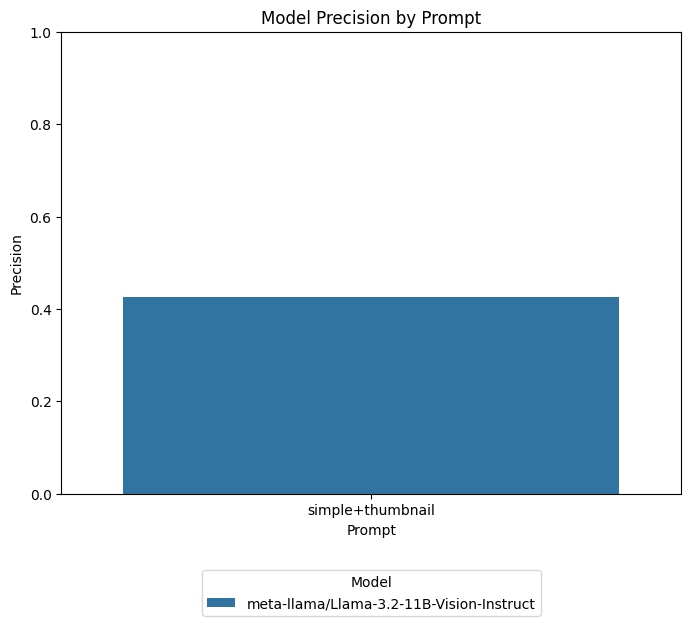

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(data=data_to_plot, x='prompt', y='precision', hue='model', palette='tab10')

# Customize the plot
plt.title("Model Precision by Prompt")
plt.xlabel("Prompt")
plt.ylabel("Precision")
plt.ylim(0, 1)
plt.legend(title='Model', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.show()

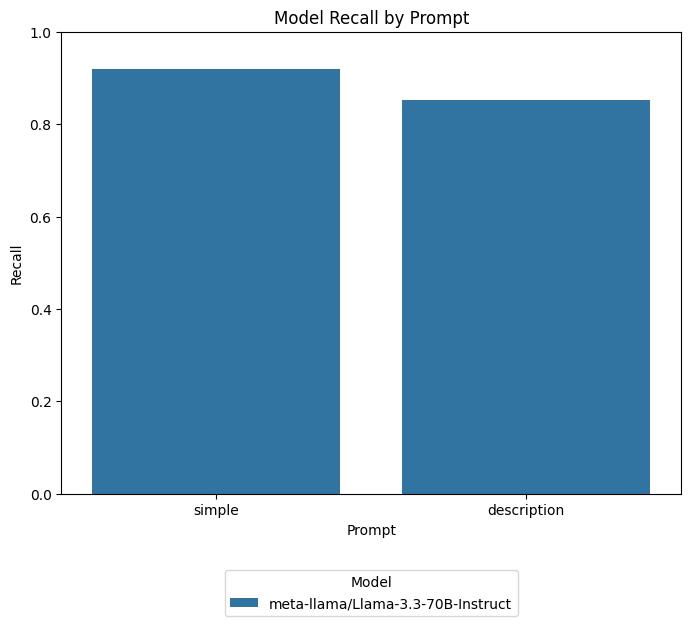

In [47]:
# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(data=data_to_plot, x='prompt', y='recall', hue='model', palette='tab10')

# Customize the plot
plt.title("Model Recall by Prompt")
plt.xlabel("Prompt")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.legend(title='Model', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.show()